<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [1]:
#imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import textwrap

/Users/ianforrest/anaconda3/envs/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ianforrest/anaconda3/envs/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ianforrest/anaconda3/envs/nn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ianforrest/anaconda3/envs/nn/lib/pyt

In [2]:
# create url variable establish conntection to path, save to text variable
url = 'https://www.gutenberg.org/files/100/100-0.txt'

path = tf.keras.utils.get_file('shakespeare.txt', url)

text = open(path, 'rb').read().decode(encoding='utf-8-sig')

In [6]:
text[0], text[1]

('\r', '\n')

In [7]:
# drop characters '\r' & '\n'
text = text.replace('\r', '')
text = text.replace('\n', '')

In [8]:
text[0], text[1]

('P', 'r')

In [9]:
# join text together
text = " ".join(text.split())

In [10]:
len(text)

5202719

In [11]:
# create list of characters, variables for number of characters and size of text
chars = list(set(text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
text_data_size = len(text)

In [12]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
#print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'/': 0, 'œ': 1, 'N': 2, 'Y': 3, 'A': 4, 'q': 5, '&': 6, 'R': 7, 'â': 8, 'u': 9, 'æ': 10, 'M': 11, 'V': 12, 'à': 13, ')': 14, 'ê': 15, '0': 16, '*': 17, '6': 18, 'n': 19, 'O': 20, 'f': 21, 'h': 22, 'F': 23, '\\': 24, 'm': 25, 'C': 26, '—': 27, 'é': 28, '2': 29, "'": 30, '`': 31, 'K': 32, 'x': 33, 'v': 34, '”': 35, '%': 36, '|': 37, '5': 38, '9': 39, ':': 40, '‘': 41, '!': 42, 'Z': 43, 'P': 44, 'B': 45, 'e': 46, 'y': 47, 'T': 48, '.': 49, 'î': 50, '#': 51, 'p': 52, '_': 53, '"': 54, 'd': 55, 'k': 56, '(': 57, '8': 58, 'G': 59, ',': 60, '$': 61, '[': 62, 's': 63, 'l': 64, 'b': 65, 'X': 66, '3': 67, '’': 68, 'z': 69, '7': 70, '?': 71, 'i': 72, 'L': 73, 'W': 74, 'D': 75, 'E': 76, 'I': 77, 'o': 78, 'j': 79, '1': 80, 't': 81, 'S': 82, 'g': 83, 'H': 84, 'r': 85, '4': 86, ']': 87, '@': 88, 'a': 89, 'É': 90, 'U': 91, 'c': 92, 'J': 93, ';': 94, 'w': 95, '“': 96, 'è': 97, 'ç': 98, 'Æ': 99, 'Q': 100, ' ': 101, '-': 102, '}': 103}
----------------------------------------------------
{0: '/', 1: 'œ'

In [21]:

text_size = len(text)
vocab = sorted(set(text))
small_text_size = 100000

# create dictionary to translate characters to int and vice versa
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = {i:u for i, u in enumerate(vocab)}#np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

seq_length = 100
# examples_per_epoch = len(text)//seq_length

X_text = []
y_text = []

for i in range(0, small_text_size - seq_length, 1):
	in_seq = text[i:i + seq_length]
	out_char = text[i + seq_length]
	X_text.append([char2idx[char] for char in in_seq])
	y_text.append(char2idx[out_char])
    
samples = len(X_text)

In [22]:
X = np.reshape(X_text, (samples, seq_length, 1))
# normalize
X = X / float(len(vocab))
# one hot encode the output variable
y = to_categorical(y_text)

In [23]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:

model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.compile(optimizer='adam', loss=loss)
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 5
BATCH_SIZE = 1024

In [34]:
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/5
99900/99900 [==============================] - 896s 9ms/sample - loss: 3.0334
Epoch 2/5
99900/99900 [==============================] - 1235s 12ms/sample - loss: 2.8866
Epoch 3/5
99900/99900 [==============================] - 1002s 10ms/sample - loss: 2.8429
Epoch 4/5
99900/99900 [==============================] - 1006s 10ms/sample - loss: 2.8141
Epoch 5/5
99900/99900 [==============================] - 1045s 10ms/sample - loss: 2.7893


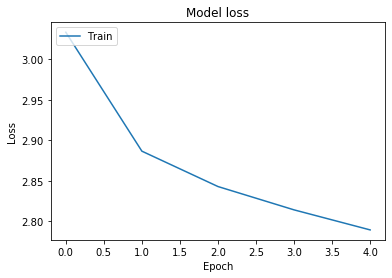

In [35]:

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [36]:
start = np.random.randint(0, len(X_text)-1)
vocab_len = len(vocab)
pattern = X_text[start]

print(f"Seed: \n {''.join([idx2char[value] for value in pattern])}")
out = [idx2char[value] for value in pattern]

# generate characters
for i in range(500):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = idx2char[index]
    in_seq = [idx2char[value] for value in pattern]
    out.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

print("\nGenerated Text:\n")
print(textwrap.fill(''.join(out), 80))

Seed: 
 hame,For since each hand hath put on nature’s power,Fairing the foul with art’s false borrowed face,

Generated Text:

hame,For since each hand hath put on nature’s power,Fairing the foul with art’s
false borrowed face,th the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the the the the the the the the the the the
the the the the the the the the the the t


# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN